In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

MODEL_DIR = r"D:\hf_models\Finetuned_Salsa"

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, local_files_only=True)
model     = AutoModelForSequenceClassification.from_pretrained(
    MODEL_DIR,
    local_files_only=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Loaded model from:", MODEL_DIR)


Loaded model from: D:\hf_models\Finetuned_Salsa


In [ ]:
from datasets import load_dataset, Value

# Reload the dataset (or reuse if it's already in memory)
dataset = load_dataset("jokerdD0727/Sarcasm_Detection")["train"]
# Rename columns
dataset = dataset.rename_columns({"headline": "text","is_sarcastic": "label"})
# Convert label to integer
dataset = dataset.map(lambda ex: {"label": int(ex["label"])})
dataset = dataset.cast_column("label", Value("int64"))
# Remove unused columns
cols_to_keep = {"text", "label"}
cols_to_drop = [c for c in dataset.column_names if c not in cols_to_keep]
dataset = dataset.remove_columns(cols_to_drop)



MAX_LEN = 128

def tokenize_batch(batch):
    enc = tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
    )
    enc["label"] = batch["label"]
    return enc

test_ds = dataset.map(tokenize_batch, batched=True)
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/28619 [00:00<?, ? examples/s]

In [ ]:
from torch.utils.data import DataLoader
import numpy as np

test_loader = DataLoader(test_ds, batch_size=32)

all_preds  = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels  = batch["label"].cpu().numpy()

        outputs = model(input_ids, mask)
        logits = outputs.logits.cpu().numpy()
        preds = logits.argmax(axis=-1)

        all_labels.extend(labels)
        all_preds.extend(preds)

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)


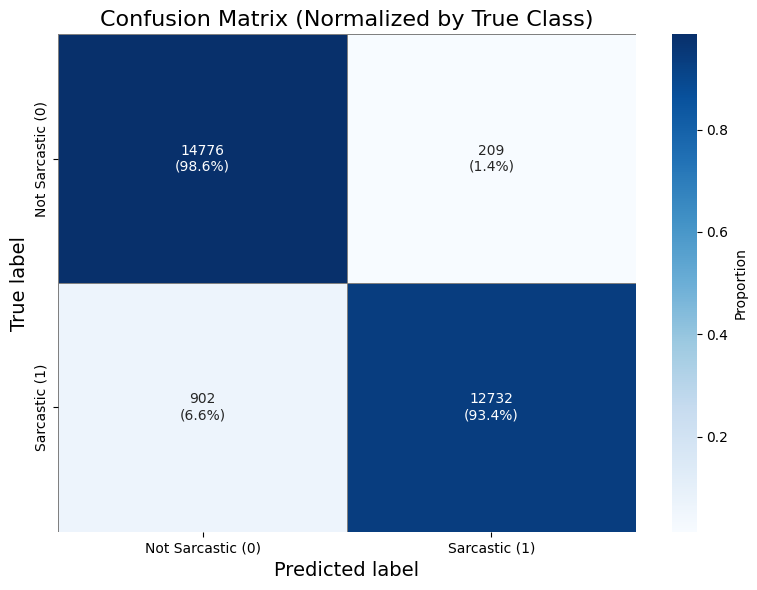

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_pretty(labels, preds):
    cm = confusion_matrix(labels, preds)
    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    labels_text = np.array([
        [f"{cm[i, j]}\n({cm_norm[i, j]*100:.1f}%)" for j in range(cm.shape[1])]
        for i in range(cm.shape[0])
    ])

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_norm,
        annot=labels_text,
        fmt="",
        cmap="Blues",
        xticklabels=["Not Sarcastic (0)", "Sarcastic (1)"],
        yticklabels=["Not Sarcastic (0)", "Sarcastic (1)"],
        cbar_kws={"label": "Proportion"},
        linewidths=0.5,
        linecolor="gray",
    )

    plt.title("Confusion Matrix (Normalized by True Class)", fontsize=16)
    plt.xlabel("Predicted label", fontsize=14)
    plt.ylabel("True label", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix_pretty(all_labels, all_preds)
